# Event Segmentation: Physical Activity Level Transitions

This notebook demonstrates how to query event data from the OCED-mHealth format

## Setup

First, let's set up our environment and import the necessary modules.

In [1]:
import datetime
import sys
# Add the project root directory to the Python path
sys.path.append('..')
from concurrent.futures import ThreadPoolExecutor
from src.oced.oced_data_query import OCEDDataQuery
from src.oced.time_objects import TimeObject

## Query OCED-mHealth Data to Retrieve Sensor Events 

#### 1. Get OCED-mHealth Data from JSON File

In [2]:
dataQuery = OCEDDataQuery()  
oced_data_file = f"oced_data_time.json"
data_dict = dataQuery.load_json(oced_data_file)

#### 2. Get sensor events data by type, filtering time

In [3]:
start_date = datetime.datetime(2025, 5, 11)
end_date = datetime.datetime(2025, 5, 12)

Load accelerometer sensor events

In [4]:
accelerometer_data_df = dataQuery.get_accelerometer_events(data_dict,  start_date=start_date, end_date=end_date) # start_date=start_date, end_date=end_date)
accelerometer_data_df.head()

Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'activity_type', 'heartrate', 'accelerometer', 'location'}
Number of accelerometer events found: 2902004
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:06.728000
  Latest timestamp: 2025-05-14 22:52:11.561000
After start date filtering: 1953612 events remaining
After end date filtering: 621534 events remaining


,timestamp,x,y,z
1950685,2025-05-11 08:44:30.622,-3.931407,5.245068,-7.372287
1950686,2025-05-11 08:44:30.642,-3.986443,5.235496,-7.341179
1950688,2025-05-11 08:44:30.643,-3.850052,5.242674,-7.259824
1950687,2025-05-11 08:44:30.643,-3.964907,5.249853,-7.302894
1950690,2025-05-11 08:44:30.678,-3.852444,5.199604,-7.211967


Load heartrate sensor events

In [5]:
heartrate_data_df = dataQuery.get_heartrate_events(data_dict, start_date=start_date, end_date=end_date)
heartrate_data_df.head()

Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'activity_type', 'heartrate', 'accelerometer', 'location'}
Number of heartrate events found: 1056730
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:26.735000
  Latest timestamp: 2025-05-21 10:55:41.609000
After start date filtering: 888140 events remaining
After end date filtering: 117311 events remaining


,timestamp,bpm,pp
887597,2025-05-11 08:44:46.363,60.0,0.0
887054,2025-05-11 08:44:46.363,60.0,0.0
887598,2025-05-11 08:44:46.444,60.0,0.0
887055,2025-05-11 08:44:46.444,60.0,0.0
887599,2025-05-11 08:44:46.524,60.0,0.0


#### 3. Clean Memory

In [6]:
del data_dict
import gc
gc.collect()  # Force garbage collection

0

#### 4. Validate sensor attribute value distribution

## Align Sensor Types 

#### 1. Analyze Time Intervals Between Sensor Events

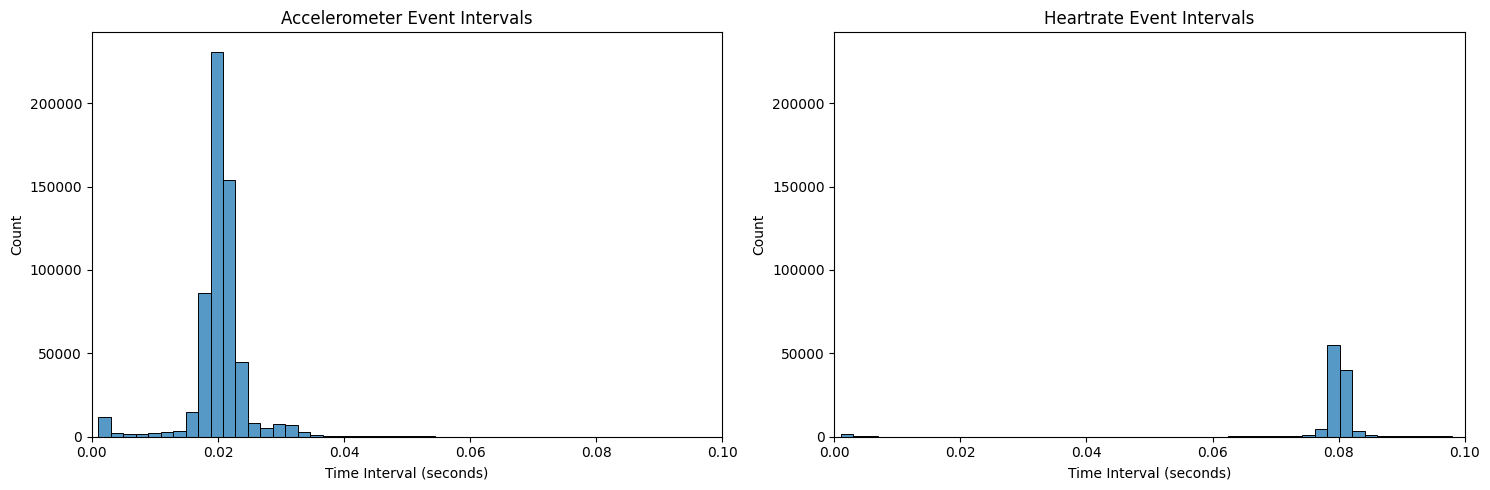


Statistics for Accelerometer intervals (all data):
Total number of intervals: 592,778
Mean interval: 0.087 seconds
Median interval: 0.020 seconds
Standard deviation: 5.748 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1016.301 seconds
95th percentile: 0.026 seconds
99th percentile: 0.036 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 591,540 (99.79%)
Intervals > 0.1 seconds: 1,238 (0.21%)
Intervals > 1 second: 218 (0.04%)
Intervals > 10 seconds: 194 (0.03%)

Statistics for Heartrate intervals (all data):
Total number of intervals: 115,179
Mean interval: 0.450 seconds
Median interval: 0.080 seconds
Standard deviation: 14.018 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1881.523 seconds
95th percentile: 0.083 seconds
99th percentile: 0.129 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 113,284 (98.35%)
Intervals > 0.1 seconds: 1,895 (1.65%)
Intervals > 1 second: 224 (0.19%)
Intervals > 10 seconds: 201 (0.17%)

Gap Analysis for Accelerometer:


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_time_intervals(df):
    """Calculate time intervals between consecutive events in seconds."""
    # Sort by timestamp to ensure correct order
    df = df.sort_values('timestamp')
    # Calculate time differences in seconds
    intervals = df['timestamp'].diff().dt.total_seconds()
    # Remove the first row (NaN) and any negative intervals (shouldn't exist)
    intervals = intervals[intervals > 0]
    return intervals

# Calculate intervals for both sensor types
accel_intervals = calculate_time_intervals(accelerometer_data_df)
hr_intervals = calculate_time_intervals(heartrate_data_df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Filter intervals <= 0.1 seconds for visualization only
accel_filtered = accel_intervals[accel_intervals <= 0.1]
hr_filtered = hr_intervals[hr_intervals <= 0.1]

# Plot histograms without KDE
sns.histplot(data=accel_filtered, bins=50, ax=ax1, kde=False)
ax1.set_title('Accelerometer Event Intervals')
ax1.set_xlabel('Time Interval (seconds)')
ax1.set_ylabel('Count')
ax1.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

sns.histplot(data=hr_filtered, bins=50, ax=ax2, kde=False)
ax2.set_title('Heartrate Event Intervals')
ax2.set_xlabel('Time Interval (seconds)')
ax2.set_ylabel('Count')
ax2.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

# Set the same y-axis limits for both plots
max_count = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, max_count)
ax2.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

# Calculate and print statistics using ALL data points
def print_statistics(intervals, sensor_type):
    print(f"\nStatistics for {sensor_type} intervals (all data):")
    print(f"Total number of intervals: {len(intervals):,}")
    print(f"Mean interval: {intervals.mean():.3f} seconds")
    print(f"Median interval: {intervals.median():.3f} seconds")
    print(f"Standard deviation: {intervals.std():.3f} seconds")
    print(f"Minimum interval: {intervals.min():.3f} seconds")
    print(f"Maximum interval: {intervals.max():.3f} seconds")
    print(f"95th percentile: {np.percentile(intervals, 95):.3f} seconds")
    print(f"99th percentile: {np.percentile(intervals, 99):.3f} seconds")
    
    # Print distribution of intervals
    print(f"\nInterval distribution:")
    print(f"Intervals ≤ 0.1 seconds: {len(intervals[intervals <= 0.1]):,} ({len(intervals[intervals <= 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 0.1 seconds: {len(intervals[intervals > 0.1]):,} ({len(intervals[intervals > 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 1 second: {len(intervals[intervals > 1]):,} ({len(intervals[intervals > 1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 10 seconds: {len(intervals[intervals > 10]):,} ({len(intervals[intervals > 10])/len(intervals)*100:.2f}%)")

print_statistics(accel_intervals, "Accelerometer")
print_statistics(hr_intervals, "Heartrate")

# Additional analysis: Check for gaps in the data
def analyze_gaps(intervals, sensor_type, threshold_seconds=60):
    gaps = intervals[intervals > threshold_seconds]
    print(f"\nGap Analysis for {sensor_type}:")
    print(f"Number of gaps > {threshold_seconds} seconds: {len(gaps):,}")
    if len(gaps) > 0:
        print(f"Largest gap: {gaps.max():.1f} seconds")
        print(f"Average gap duration: {gaps.mean():.1f} seconds")

analyze_gaps(accel_intervals, "Accelerometer")
analyze_gaps(hr_intervals, "Heartrate")

Define the ACTUAL sampling frequency of each sensor type 

In [12]:
acc_sample_f = 1/accel_intervals.median()
hr_sample_f = 1/hr_intervals.median()